In [6]:
import torch
torch.manual_seed(123)
import random
random.seed(123)

import config

import torch.nn as nn
import os
import shutil
import itertools


from chofer_torchex.utils.data.collate import dict_sample_target_iter_concat
from chofer_torchex.utils.functional import collection_cascade, cuda_cascade
from chofer_tda_datasets import Animal
from jmlr_2018_code.utils import *
from chofer_torchex.nn.slayer import SLayerExponential, \
SLayerRational, \
LinearRationalStretchedBirthLifeTimeCoordinateTransform, \
prepare_batch, SLayerRationalHat
from sklearn.model_selection import ShuffleSplit
from collections import Counter, defaultdict
from torch.utils.data import DataLoader, SubsetRandomSampler
from collections import OrderedDict
from torch.autograd import Variable

from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib notebook
%load_ext autoreload
%autoreload 2

os.environ['CUDA_VISIBLE_DEVICES'] = str(0)


class train_env:
    nu = 0.01
    n_epochs = 200
    lr_initial = 0.01
    momentum = 0.9
    lr_epoch_step = 40
    batch_size = 100
    train_size = 0.9
    

coordinate_transform = LinearRationalStretchedBirthLifeTimeCoordinateTransform(nu=train_env.nu)
            

used_directions = ['dim_0_dir_{}'.format(i) for i in range(0, 32,2)]
dataset = Animal(root_dir=config.paths.data_root_dir)
dataset.data_transforms = [
                           lambda x: {k: x[k] for k in used_directions}, 
                           numpy_to_torch_cascade,
                           lambda x: collection_cascade(x, 
                                                        lambda x: isinstance(x, torch.Tensor), 
                                                        lambda x: coordinate_transform(x))
                           ]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found data!


In [7]:
class PHTCollate:   
    def __init__(self, nu, cuda=True, rotation_augmentation=False):
        self.cuda = cuda
        self.rotation_augmentation = rotation_augmentation
        
    def __call__(self, sample_target_iter):
        
        augmented_samples = []
        if self.rotation_augmentation:
            samples, targets = [], []
            for x, y in sample_target_iter:                
                i = random.randint(0, len(used_directions)-1)
                shifted_keys = used_directions[i:] + used_directions[:i]                
                
                samples.append({k: x[ki] for k, ki in zip(used_directions, shifted_keys)})
                targets.append(y)
                
            sample_target_iter = zip(samples, targets)

        x, y = dict_sample_target_iter_concat(sample_target_iter)                                            
                                              
        for k in x.keys():
            batch_view = x[k]
            x[k] = prepare_batch(batch_view, 2)                  

        y = torch.LongTensor(y)    

        if self.cuda:
            # Shifting the necessary parts of the prepared batch to the cuda
            x = {k: collection_cascade(v,
                                       lambda x: isinstance(x, tuple),
                                       lambda x: (x[0].cuda(), x[1].cuda(), x[2], x[3]))
                 for k, v in x.items()}

            y = y.cuda()

        return x, y                       
    
collate_fn = PHTCollate(train_env.nu, cuda=True)

In [8]:
def Slayer(n_elements):
    return SLayerRationalHat(n_elements, radius_init=0.25, exponent=1)

def LinearCell(n_in, n_out):
    m = nn.Sequential(nn.Linear(n_in, n_out), 
                      nn.BatchNorm1d(n_out), 
                      nn.ReLU(),
                     )
    m.out_features = m[0].out_features
    return m


class AnimalModel(nn.Module):
    def __init__(self):
        super().__init__()   
        self.n_elements = 100
        
        self.slayers = ModuleDict()
        for k in used_directions:
            s = Slayer(self.n_elements)
            self.slayers[k] = nn.Sequential(s)            
            
        cls_in_dim = len(used_directions)*self.n_elements
        self.cls = nn.Sequential(
                                nn.Dropout(0.3),
                                LinearCell(cls_in_dim, int(cls_in_dim/4)),    
                                nn.Dropout(0.2),
                                LinearCell(int(cls_in_dim/4), int(cls_in_dim/16)),  
                                nn.Dropout(0.1),
                                nn.Linear(int(cls_in_dim/16), 20))
        
    def forward(self, input):
        x = []
        for k in used_directions:            
            xx = self.slayers[k](input[k])
            x.append(xx)

        x = torch.cat(x, dim=1)          
        x = self.cls(x)       
                                              
        return x
    
    def center_init(self, sample_target_iter):
        centers = k_means_center_init(sample_target_iter, self.n_elements)
        
        for k, v in centers.items():
            self.slayers._modules[k][0].centers.data = v
            
            
    def parameters(self):
        return self.cls.parameters()
            
            

In [12]:
stats_of_runs = []
def experiment():    
    
    splitter = StratifiedShuffleSplit(n_splits=10, 
                                      train_size=train_env.train_size, 
                                      test_size=1-train_env.train_size, 
                                      random_state=123)
    train_test_splits = list(splitter.split(X=dataset.labels, y=dataset.labels))
    train_test_splits = [(train_i.tolist(), test_i.tolist()) for train_i, test_i in train_test_splits]
    
    for run_i, (train_i, test_i) in enumerate(train_test_splits):
        print('')
        print('Run', run_i)     

        model = AnimalModel()
        model.center_init([dataset[i] for i in train_i])
        model.cuda()

        stats = defaultdict(list)
        stats_of_runs.append(stats)
        
        opt = torch.optim.SGD(model.parameters(), lr=train_env.lr_initial, momentum=train_env.momentum)

        for i_epoch in range(1, train_env.n_epochs+1):      

            model.train()
            
#             train_sampler = [i for i in train_i]
#             random.shuffle(train_sampler)
            dl_train = DataLoader(dataset,
                                  batch_size=train_env.batch_size, 
                                  collate_fn=collate_fn,
                                  sampler=SubsetRandomSampler(train_i))

            dl_test = DataLoader(dataset,
                                 batch_size=train_env.batch_size, 
                                 collate_fn=collate_fn, 
                                 sampler=SubsetRandomSampler(test_i))

            epoch_loss = 0    

            if i_epoch % train_env.lr_epoch_step == 0:
                adapt_lr(opt, lambda lr: lr*0.5)

            for i_batch, (x, y) in enumerate(dl_train, 1):              

                y = torch.autograd.Variable(y)

                def closure():
                    opt.zero_grad()
                    y_hat = model(x)            
                    loss = nn.functional.cross_entropy(y_hat, y)   
                    loss.backward()
                    return loss

                loss = opt.step(closure)

                epoch_loss += float(loss)
                stats['loss_by_batch'].append(float(loss))
                stats['centers'].append(model.slayers['dim_0_dir_0'][0].centers.data.cpu().numpy())

                print("Epoch {}/{}, Batch {}/{}".format(i_epoch, train_env.n_epochs, i_batch, len(dl_train)), end="       \r")

            stats['train_loss_by_epoch'].append(epoch_loss/len(dl_train))            
                     
            model.eval()    
            true_samples = 0
            seen_samples = 0
            epoch_test_loss = 0
            for i_batch, (x, y) in enumerate(dl_test):

                y_hat = model(x)
                epoch_test_loss += float(nn.functional.cross_entropy(y_hat, torch.autograd.Variable(y.cuda())).data)

                y_hat = y_hat.max(dim=1)[1].data.long()

                true_samples += (y_hat == y).sum()
                seen_samples += y.size(0)  

            test_acc = true_samples.item()/seen_samples
            stats['test_accuracy'].append(test_acc)
            stats['test_loss_by_epoch'].append(epoch_test_loss/len(dl_test))
            print('')
            print(test_acc)
            
        print('')
        print('acc.', np.mean(stats['test_accuracy'][-10:]))
#     return stats_of_runs

experiment()
# stats_of_runs = experiment()


Run 0
Epoch 1/200, Batch 18/18       
0.09
Epoch 2/200, Batch 18/18       
0.355
Epoch 3/200, Batch 18/18       
0.39
Epoch 4/200, Batch 18/18       
0.42
Epoch 5/200, Batch 18/18       
0.445
Epoch 6/200, Batch 18/18       
0.47
Epoch 7/200, Batch 18/18       
0.5
Epoch 8/200, Batch 18/18       
0.545
Epoch 9/200, Batch 18/18       
0.565
Epoch 10/200, Batch 18/18       
0.535
Epoch 11/200, Batch 18/18       
0.585
Epoch 12/200, Batch 18/18       
0.62
Epoch 13/200, Batch 18/18       
0.58
Epoch 14/200, Batch 18/18       
0.595
Epoch 15/200, Batch 18/18       
0.615
Epoch 16/200, Batch 18/18       
0.61
Epoch 17/200, Batch 18/18       
0.595
Epoch 18/200, Batch 18/18       
0.665
Epoch 19/200, Batch 18/18       
0.635
Epoch 20/200, Batch 18/18       
0.6
Epoch 21/200, Batch 18/18       
0.65
Epoch 22/200, Batch 18/18       
0.65
Epoch 23/200, Batch 18/18       
0.65
Epoch 24/200, Batch 18/18       
0.665
Epoch 25/200, Batch 18/18       
0.63
Epoch 26/200, Batch 18/18       
0.69
Epoc

Epoch 11/200, Batch 18/18       
0.56
Epoch 12/200, Batch 18/18       
0.57
Epoch 13/200, Batch 18/18       
0.575
Epoch 14/200, Batch 18/18       
0.595
Epoch 15/200, Batch 18/18       
0.615
Epoch 16/200, Batch 18/18       
0.585
Epoch 17/200, Batch 18/18       
0.605
Epoch 18/200, Batch 18/18       
0.595
Epoch 19/200, Batch 18/18       
0.605
Epoch 20/200, Batch 18/18       
0.615
Epoch 21/200, Batch 18/18       
0.63
Epoch 22/200, Batch 18/18       
0.605
Epoch 23/200, Batch 18/18       
0.615
Epoch 24/200, Batch 18/18       
0.625
Epoch 25/200, Batch 18/18       
0.61
Epoch 26/200, Batch 18/18       
0.645
Epoch 27/200, Batch 18/18       
0.66
Epoch 28/200, Batch 18/18       
0.625
Epoch 29/200, Batch 18/18       
0.625
Epoch 30/200, Batch 18/18       
0.635
Epoch 31/200, Batch 18/18       
0.63
Epoch 32/200, Batch 18/18       
0.63
Epoch 33/200, Batch 18/18       
0.62
Epoch 34/200, Batch 18/18       
0.68
Epoch 35/200, Batch 18/18       
0.665
Epoch 36/200, Batch 18/18       
0

Epoch 21/200, Batch 18/18       
0.735
Epoch 22/200, Batch 18/18       
0.745
Epoch 23/200, Batch 18/18       
0.69
Epoch 24/200, Batch 18/18       
0.74
Epoch 25/200, Batch 18/18       
0.705
Epoch 26/200, Batch 18/18       
0.725
Epoch 27/200, Batch 18/18       
0.72
Epoch 28/200, Batch 18/18       
0.705
Epoch 29/200, Batch 18/18       
0.71
Epoch 30/200, Batch 18/18       
0.73
Epoch 31/200, Batch 18/18       
0.72
Epoch 32/200, Batch 18/18       
0.735
Epoch 33/200, Batch 18/18       
0.71
Epoch 34/200, Batch 18/18       
0.715
Epoch 35/200, Batch 18/18       
0.72
Epoch 36/200, Batch 18/18       
0.725
Epoch 37/200, Batch 18/18       
0.73
Epoch 38/200, Batch 18/18       
0.74
Epoch 39/200, Batch 18/18       
0.75
Epoch 40/200, Batch 18/18       
0.705
Epoch 41/200, Batch 18/18       
0.73
Epoch 42/200, Batch 18/18       
0.76
Epoch 43/200, Batch 18/18       
0.755
Epoch 44/200, Batch 18/18       
0.745
Epoch 45/200, Batch 18/18       
0.735
Epoch 46/200, Batch 18/18       
0.75


Epoch 31/200, Batch 18/18       
0.695
Epoch 32/200, Batch 18/18       
0.705
Epoch 33/200, Batch 18/18       
0.65
Epoch 34/200, Batch 18/18       
0.705
Epoch 35/200, Batch 18/18       
0.7
Epoch 36/200, Batch 18/18       
0.67
Epoch 37/200, Batch 18/18       
0.725
Epoch 38/200, Batch 18/18       
0.665
Epoch 39/200, Batch 18/18       
0.72
Epoch 40/200, Batch 18/18       
0.74
Epoch 41/200, Batch 18/18       
0.72
Epoch 42/200, Batch 18/18       
0.72
Epoch 43/200, Batch 18/18       
0.715
Epoch 44/200, Batch 18/18       
0.7
Epoch 45/200, Batch 18/18       
0.725
Epoch 46/200, Batch 18/18       
0.705
Epoch 47/200, Batch 18/18       
0.705
Epoch 48/200, Batch 18/18       
0.705
Epoch 49/200, Batch 18/18       
0.71
Epoch 50/200, Batch 18/18       
0.7
Epoch 51/200, Batch 18/18       
0.685
Epoch 52/200, Batch 18/18       
0.72
Epoch 53/200, Batch 18/18       
0.7
Epoch 54/200, Batch 18/18       
0.715
Epoch 55/200, Batch 18/18       
0.705
Epoch 56/200, Batch 18/18       
0.715
Ep

Epoch 40/200, Batch 18/18       
0.735
Epoch 41/200, Batch 18/18       
0.74
Epoch 42/200, Batch 18/18       
0.74
Epoch 43/200, Batch 18/18       
0.73
Epoch 44/200, Batch 18/18       
0.735
Epoch 45/200, Batch 18/18       
0.74
Epoch 46/200, Batch 18/18       
0.72
Epoch 47/200, Batch 18/18       
0.735
Epoch 48/200, Batch 18/18       
0.725
Epoch 49/200, Batch 18/18       
0.725
Epoch 50/200, Batch 18/18       
0.74
Epoch 51/200, Batch 18/18       
0.73
Epoch 52/200, Batch 18/18       
0.755
Epoch 53/200, Batch 18/18       
0.75
Epoch 54/200, Batch 18/18       
0.755
Epoch 55/200, Batch 18/18       
0.725
Epoch 56/200, Batch 18/18       
0.73
Epoch 57/200, Batch 18/18       
0.755
Epoch 58/200, Batch 18/18       
0.75
Epoch 59/200, Batch 18/18       
0.745
Epoch 60/200, Batch 18/18       
0.75
Epoch 61/200, Batch 18/18       
0.74
Epoch 62/200, Batch 18/18       
0.735
Epoch 63/200, Batch 18/18       
0.72
Epoch 64/200, Batch 18/18       
0.74
Epoch 65/200, Batch 18/18       
0.73
E

Epoch 50/200, Batch 18/18       
0.72
Epoch 51/200, Batch 18/18       
0.715
Epoch 52/200, Batch 18/18       
0.705
Epoch 53/200, Batch 18/18       
0.725
Epoch 54/200, Batch 18/18       
0.7
Epoch 55/200, Batch 18/18       
0.735
Epoch 56/200, Batch 18/18       
0.725
Epoch 57/200, Batch 18/18       
0.73
Epoch 58/200, Batch 18/18       
0.72
Epoch 59/200, Batch 18/18       
0.735
Epoch 60/200, Batch 18/18       
0.745
Epoch 61/200, Batch 18/18       
0.73
Epoch 62/200, Batch 18/18       
0.73
Epoch 63/200, Batch 18/18       
0.73
Epoch 64/200, Batch 18/18       
0.765
Epoch 65/200, Batch 18/18       
0.74
Epoch 66/200, Batch 18/18       
0.745
Epoch 67/200, Batch 18/18       
0.72
Epoch 68/200, Batch 18/18       
0.725
Epoch 69/200, Batch 18/18       
0.74
Epoch 70/200, Batch 18/18       
0.74
Epoch 71/200, Batch 18/18       
0.74
Epoch 72/200, Batch 18/18       
0.735
Epoch 73/200, Batch 18/18       
0.745
Epoch 74/200, Batch 18/18       
0.73
Epoch 75/200, Batch 18/18       
0.735


Epoch 60/200, Batch 18/18       
0.725
Epoch 61/200, Batch 18/18       
0.735
Epoch 62/200, Batch 18/18       
0.75
Epoch 63/200, Batch 18/18       
0.73
Epoch 64/200, Batch 18/18       
0.74
Epoch 65/200, Batch 18/18       
0.745
Epoch 66/200, Batch 18/18       
0.73
Epoch 67/200, Batch 18/18       
0.75
Epoch 68/200, Batch 18/18       
0.72
Epoch 69/200, Batch 18/18       
0.735
Epoch 70/200, Batch 18/18       
0.735
Epoch 71/200, Batch 18/18       
0.74
Epoch 72/200, Batch 18/18       
0.71
Epoch 73/200, Batch 18/18       
0.735
Epoch 74/200, Batch 18/18       
0.745
Epoch 75/200, Batch 18/18       
0.715
Epoch 76/200, Batch 18/18       
0.74
Epoch 77/200, Batch 18/18       
0.715
Epoch 78/200, Batch 18/18       
0.715
Epoch 79/200, Batch 18/18       
0.72
Epoch 80/200, Batch 18/18       
0.74
Epoch 81/200, Batch 18/18       
0.735
Epoch 82/200, Batch 18/18       
0.725
Epoch 83/200, Batch 18/18       
0.73
Epoch 84/200, Batch 18/18       
0.74
Epoch 85/200, Batch 18/18       
0.735

Epoch 70/200, Batch 18/18       
0.735
Epoch 71/200, Batch 18/18       
0.7
Epoch 72/200, Batch 18/18       
0.735
Epoch 73/200, Batch 18/18       
0.72
Epoch 74/200, Batch 18/18       
0.725
Epoch 75/200, Batch 18/18       
0.725
Epoch 76/200, Batch 18/18       
0.69
Epoch 77/200, Batch 18/18       
0.725
Epoch 78/200, Batch 18/18       
0.705
Epoch 79/200, Batch 18/18       
0.705
Epoch 80/200, Batch 18/18       
0.715
Epoch 81/200, Batch 18/18       
0.705
Epoch 82/200, Batch 18/18       
0.715
Epoch 83/200, Batch 18/18       
0.725
Epoch 84/200, Batch 18/18       
0.71
Epoch 85/200, Batch 18/18       
0.705
Epoch 86/200, Batch 18/18       
0.7
Epoch 87/200, Batch 18/18       
0.725
Epoch 88/200, Batch 18/18       
0.735
Epoch 89/200, Batch 18/18       
0.72
Epoch 90/200, Batch 18/18       
0.735
Epoch 91/200, Batch 18/18       
0.7
Epoch 92/200, Batch 18/18       
0.725
Epoch 93/200, Batch 18/18       
0.715
Epoch 94/200, Batch 18/18       
0.7
Epoch 95/200, Batch 18/18       
0.72

Epoch 80/200, Batch 18/18       
0.74
Epoch 81/200, Batch 18/18       
0.725
Epoch 82/200, Batch 18/18       
0.705
Epoch 83/200, Batch 18/18       
0.725
Epoch 84/200, Batch 18/18       
0.715
Epoch 85/200, Batch 18/18       
0.73
Epoch 86/200, Batch 18/18       
0.735
Epoch 87/200, Batch 18/18       
0.72
Epoch 88/200, Batch 18/18       
0.73
Epoch 89/200, Batch 18/18       
0.715
Epoch 90/200, Batch 18/18       
0.72
Epoch 91/200, Batch 18/18       
0.72
Epoch 92/200, Batch 18/18       
0.73
Epoch 93/200, Batch 18/18       
0.735
Epoch 94/200, Batch 18/18       
0.735
Epoch 95/200, Batch 18/18       
0.71
Epoch 96/200, Batch 18/18       
0.715
Epoch 97/200, Batch 18/18       
0.735
Epoch 98/200, Batch 18/18       
0.73
Epoch 99/200, Batch 18/18       
0.755
Epoch 100/200, Batch 18/18       
0.725
Epoch 101/200, Batch 18/18       
0.73
Epoch 102/200, Batch 18/18       
0.71
Epoch 103/200, Batch 18/18       
0.74
Epoch 104/200, Batch 18/18       
0.735
Epoch 105/200, Batch 18/18      

Epoch 90/200, Batch 18/18       
0.75
Epoch 91/200, Batch 18/18       
0.77
Epoch 92/200, Batch 18/18       
0.765
Epoch 93/200, Batch 18/18       
0.775
Epoch 94/200, Batch 18/18       
0.77
Epoch 95/200, Batch 18/18       
0.775
Epoch 96/200, Batch 18/18       
0.775
Epoch 97/200, Batch 18/18       
0.76
Epoch 98/200, Batch 18/18       
0.775
Epoch 99/200, Batch 18/18       
0.775
Epoch 100/200, Batch 18/18       
0.78
Epoch 101/200, Batch 18/18       
0.76
Epoch 102/200, Batch 18/18       
0.785
Epoch 103/200, Batch 18/18       
0.785
Epoch 104/200, Batch 18/18       
0.795
Epoch 105/200, Batch 18/18       
0.775
Epoch 106/200, Batch 18/18       
0.77
Epoch 107/200, Batch 18/18       
0.78
Epoch 108/200, Batch 18/18       
0.765
Epoch 109/200, Batch 18/18       
0.78
Epoch 110/200, Batch 18/18       
0.78
Epoch 111/200, Batch 18/18       
0.78
Epoch 112/200, Batch 18/18       
0.765
Epoch 113/200, Batch 18/18       
0.775
Epoch 114/200, Batch 18/18       
0.79
Epoch 115/200, Batch 1

In [7]:
# print(np.mean([np.mean(s['test_accuracy'][-10:]) for s in stats_of_runs]))
accs = [np.mean(s['test_accuracy'][-10:]) for s in stats_of_runs]
print(accs)
print(np.mean(accs))
print(np.std(accs))



[0.7, 0.6880000000000001, 0.7665000000000001, 0.7244999999999999, 0.7425, 0.785, 0.747, 0.7124999999999999, 0.7424999999999999, 0.773]
0.7381499999999999
0.03023908894130247


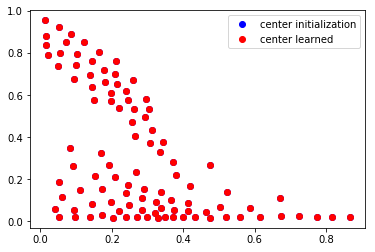

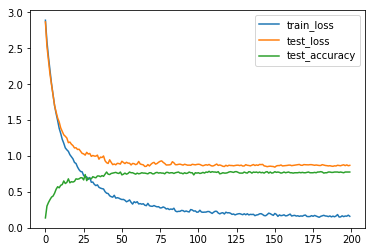

In [6]:

stats = stats_of_runs[-1]
plt.figure()

if 'centers' in stats:
    c_start = stats['centers'][0]
    c_end = stats['centers'][-1]

    plt.plot(c_start[:,0], c_start[:, 1], 'bo', label='center initialization')
    plt.plot(c_end[:,0], c_end[:, 1], 'ro', label='center learned')

    all_centers = numpy.stack(stats['centers'], axis=0)
    for i in range(all_centers.shape[1]):
        points = all_centers[:,i, :]
        plt.plot(points[:, 0], points[:, 1], '-k', alpha=0.25)
        

    plt.legend()
    
plt.figure()
plt.plot(stats['train_loss_by_epoch'], label='train_loss')
plt.plot(stats['test_loss_by_epoch'], label='test_loss')
plt.plot(stats['test_accuracy'], label='test_accuracy')


plt.legend()
plt.show()


In [ ]:
stats['test_accuracy'][90:150]

In [8]:
model.slayers['dim_0_dir_0'].radius.min()

NameError: name 'model' is not defined